### 목표
    - 문제정의
        - 500명의 키와 몸무게 , 비만도 라벨을 이용하여 비만을 판단하는 모델을 만들어보자.
        - 머신러닝 과정을 이해해보자.

In [1]:
# 판다스, 시각화
import pandas as pd
import matplotlib.pyplot as plt
# 모델 관련한 불러오는 코드 (2줄)
# knn 모델 불러오기, 측정 도구 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### 데이터 준비(수집)

In [5]:
# pd.read_csv('파일 경로 설정')
# data 변수에 담아주기
# Label 컬럼을 인덱스로 설정해서 불러오기
data = pd.read_csv('./data/bmi_500.csv', index_col='Label')
data

,Gender,Height,Weight
Label,,,
Obesity,Male,174,96
Normal,Male,189,87
Obesity,Female,185,110
Overweight,Female,195,104
Overweight,Male,149,61
...,...,...,...
Extreme Obesity,Female,150,153
Obesity,Female,184,121
Extreme Obesity,Female,141,136


In [7]:
# 데이터 정보 확인해보기
# 전체 행, 컬럼 정보, 결측치 여부 확인
data.info()
# shape: (500,3)
# 성별 컬럼, 키, 몸무게 모두 결측치 x
# 데이터 확인 필수 ! -> 머신러닝 모델은 문자를 이해할 수 없음
# 이번 실습에서는 Height, Weight, Label 3개만 활용

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, Obesity to Extreme Obesity
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 15.6+ KB


### 데이터 전처리: pass

### 데이터 분석(탐색)
    - 기술 통계 확인: 평균, 최소, 중앙(오름차순으로 줄세웠을 때 정중앙에 있는 값),최대
    - 시각화를 통해 데이터의 분포 확인해보기

In [10]:
# describe()
# int, float 컬럼들에 대해서 먼저 작용
data.describe()
# 현재 data 안에는 비만에 대한 사람의 데이터 많이 있음을 알 수 있음

,Height,Weight
count,500.000000,500.000000
mean,169.944000,106.000000
std,16.375261,32.382607
min,140.000000,50.000000
25%,156.000000,80.000000
50%,170.500000,106.000000
75%,184.000000,136.000000
max,199.000000,160.000000


In [14]:
# 먼저 Label 확인이 필요함
# 중복없이 Label 확인해보자
data.index.unique()

# 'Extreme Obesity' 고도비만
# 'Obesity' 비만
# 'Overweight' 과체중
# 'Normal' 정상체중
# 'Weak' 저체중
# 'Extremely Weak' 극심한 저체중

Index(['Obesity', 'Normal', 'Overweight', 'Extreme Obesity', 'Weak',
       'Extremely Weak'],
      dtype='object', name='Label')

In [16]:
# 각각의 값의 횟수를 셀 수 있는 함수(기능)
# value_counts()
data.index.value_counts()

Extreme Obesity    198
Obesity            130
Normal              69
Overweight          68
Weak                22
Extremely Weak      13
Name: Label, dtype: int64

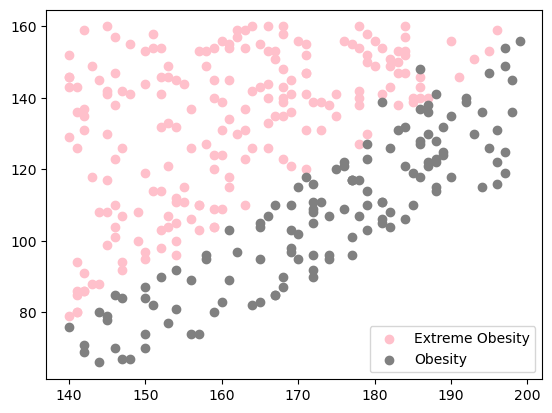

In [39]:
# 시각화 해보기 : 비만도 레이블을 표현해보기
# x축 키, y축 몸무게를 기준으로
# Extreme Obesity 에 해당하는 행만 접근하기
# loc[행인덱싱]
d = data.loc['Extreme Obesity'] # .shape 크기확인
plt.scatter(d['Height'], d['Weight'], c='pink', label='Extreme Obesity') # d.loc[:,'Height']

# Obesity 행만 접근해보기 -> d2
# 산점도 표현해보기
d2 = data.loc['Obesity']
plt.scatter(d2['Height'], d2['Weight'], c='gray', label='Obesity')
plt.legend() # 범례표시
plt.show()

In [41]:
# 그래프를 그리는 함수 정의
def bmi_draw(label, color):
    d2 = data.loc[label]
    plt.scatter(d2['Height'], d2['Weight'], c=color, label=label)

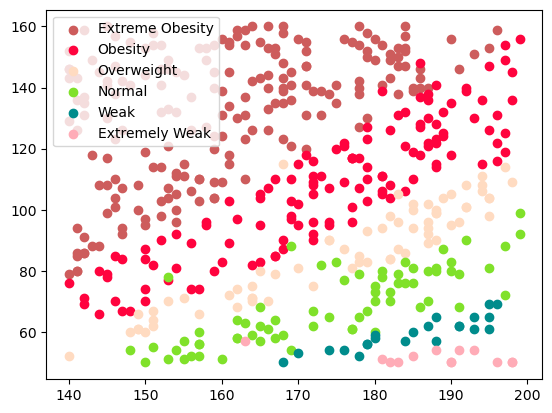

In [48]:
# Label 을 하나씩 연결하면서, 색감도 설정하면서 함수를 6번 호출(사용)
bmi_draw('Extreme Obesity', '#CD5C5C')
bmi_draw('Obesity', '#FF033E')
bmi_draw('Overweight', '#FFDBC1')
bmi_draw('Normal', '#80E12A')
bmi_draw('Weak', '#008C8C')
bmi_draw('Extremely Weak', '#FFACB7')
plt.legend()
plt.show()

### 모델링
    - 모델 선택 및 하이퍼 파라미터 조정(knn모델 선택)
    - 모델 학습
    - 모델 예측 및 평가

In [51]:
# 인덱스에 있는 label을 컬럼쪽으로 연결하기(이동하기) : df.rest_index()
# 컬럼명 확인 df.columns
data2 = data.reset_index() # 원본을 유지하고 싶다면 새로운 변수명으로 대입
data2
# data index 가 Label로 된 상태가 그대로 유지됨(원본 유지)

,Label,Gender,Height,Weight
0,Obesity,Male,174,96
1,Normal,Male,189,87
2,Obesity,Female,185,110
3,Overweight,Female,195,104
4,Overweight,Male,149,61
...,...,...,...,...
495,Extreme Obesity,Female,150,153
496,Obesity,Female,184,121
497,Extreme Obesity,Female,141,136
498,Extreme Obesity,Male,150,95


In [66]:
# 인덱싱 설명
# numpy 2차원일 때
import numpy as np
arr = np.arange(0,10).reshape(2,5)
display(arr)
# 1번째 행 접근
display(arr[1])
# 숫자 8이라는 데이터 접근 arr[행][열]
display(arr[1][3])
# 숫자 4에 접근하기
display(arr[0][4])
display(arr[0,4])
# arr[행][열] -> arr[행,열]

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

array([5, 6, 7, 8, 9])

8

4

4

In [ ]:
# Pandas에서
# loc, iloc 인덱서를 사용해야 가능
# df.loc[행,열]
# df.iloc[행,열]

# 행 데이터 접근
# df.loc[행] , df.loc[값:값] --> df.loc[행:행]
# df.iloc[행], df.iloc[값:값] --> df.iloc[행:행]

# 열 데이터 접근
# df.loc[:,열], df.loc[:, 열:열]
# df.iloc[:,열인덱스], df.loc[:, 열인덱스:열인덱스]

# 행,열 접근
# df.loc[시작행:끝행, 시작열:끝열]
# df.iloc[시작행인덱스:끝행인덱스, 시작열인덱스:끝열인덱스]

In [67]:
# 문제, 답(컬럼분리)
X_train = data2.loc[:,'Height':'Weight'] # 끝까지면 생략가능
y_train = data2.loc[:,'Label'] 

# 크기확인
print('문제크기:', X_train.shape)
print('답크기:', y_train.shape)

문제크기: (500, 2)
답크기: (500,)


In [ ]:
# 행이 총 몇개? 500
# train, test데이터로 분리하는 비율
# 7:3 (7.5:2.5) ,(8:2)
# X_train, y_train, X_test, y_test
# 500개 중에서 70%에 속하는 데이터의 개수는?